# Extended Data Fig. 7

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import pulp as p
from scipy import stats
import scipy as scipy
import matplotlib.patches as mpatches

In [2]:
#pip install pyppeteer

In [3]:
#pip install pulp

In [4]:
# don't print warning messages
import warnings
warnings.filterwarnings('ignore')

In [5]:
def warburgModel(Glucose_Uptake_Rate, Y_Glyc, Y_Resp, V_Resp, V_Glyc, Mass_Fract_ATP, organism):
    
    '''The Warburg Model primary function is this publication. The function utilizes the analytical solution to 
    maximize the ATP production rate (umol ATP per mg cellular protein per min) 
    by assigning the functional fraction of fermentation and respiration in the ATP-producing proteome.
    
    The inputs into the model are:
    (1) glucose glucose uptake rate (umol glucose per mg cellular protein per min)- Glucose_Uptake_Rate
    (2) ATP Yield per molecule of glucose for fermentation and respiation - Y_Glyc & Y_Resp
    (3) Specific activity of fermentation and respiation (umol per mg pathway protein per min) - V_Resp & V_Glyc
    (4) Fraction of the proteome for ATP-producing enzymes - Mass_Fract_ATP
    
    The outputs of the function are:
    (1) Functional proteome occupancy of fermentation and respiration -  Mass_Fract_Glyc & Mass_Fract_Resp
    (2) Maximal ATP production rate - ATP production rate (umol per mg cellular protein per min)
    (3) Rate of fermentation and respiration that produce the maximal ATP production rate - Lact_rate & Resp_rate (umol per mg cellular protein per min)'''

    if V_Glyc * Y_Glyc > V_Resp * Y_Resp and V_Glyc * Mass_Fract_ATP <= Glucose_Uptake_Rate:
        #print(1)
        Mass_Fract_Glyc = max(0, Mass_Fract_ATP)
        Mass_Fract_Resp = 0
    elif V_Glyc * Y_Glyc < V_Resp * Y_Resp and V_Resp * Mass_Fract_ATP <= Glucose_Uptake_Rate:
        #print(2)
        Mass_Fract_Glyc = 0
        Mass_Fract_Resp = max(0, Mass_Fract_ATP)
    elif Y_Glyc > Y_Resp and V_Glyc * Mass_Fract_ATP >= Glucose_Uptake_Rate:
        #print(3)
        Mass_Fract_Glyc = max(0, Glucose_Uptake_Rate / V_Glyc)
        Mass_Fract_Resp = 0
    elif Y_Glyc < Y_Resp and V_Resp * Mass_Fract_ATP >= Glucose_Uptake_Rate:
        #print(4)
        Mass_Fract_Glyc = 0
        Mass_Fract_Resp = max(0, Glucose_Uptake_Rate / V_Resp)
    else: 
        #print(5)
        Mass_Fract_Glyc = max(0, (Mass_Fract_ATP * V_Resp - Glucose_Uptake_Rate) / (V_Resp-V_Glyc))
        Mass_Fract_Resp = max(0, (Glucose_Uptake_Rate - Mass_Fract_ATP * V_Glyc) / (V_Resp-V_Glyc))

    ATP_rate = Y_Glyc * V_Glyc * Mass_Fract_Glyc + Y_Resp * V_Resp * Mass_Fract_Resp 
    if organism == 'ecoli': 
        
        #Calculation of Acetate Production and Oxygen Consumption Rates
        #Note the a seperate calculation in in necessary for E. coli since Acetate Respiration Consumes Oxygen
        Lact_rate = 2 * p.value(Mass_Fract_Glyc) * V_Glyc
        Resp_rate = 6 * p.value(Mass_Fract_Resp) * V_Resp + p.value(Mass_Fract_Glyc) * 2 * V_Glyc
    
    else:  
        
        #Calculation of Ethanol/Lactate Production and Oxygen Consumption Rates
        Lact_rate = 2 * p.value(Mass_Fract_Glyc) * V_Glyc
        Resp_rate = 6 * p.value(Mass_Fract_Resp) * V_Resp
    
    df = pd.DataFrame({'gluc' : [Glucose_Uptake_Rate], 
                       'glyc_mass' : [Mass_Fract_Glyc], 'resp_mass' : [Mass_Fract_Resp], 
                       'lact' : [Lact_rate], 'o2' : [Resp_rate]})
  
    # Printing the final solution
    return(Mass_Fract_Glyc, Mass_Fract_Resp, ATP_rate, Lact_rate, Resp_rate) 



In [6]:
def warburgCI(df): 
    
    '''Calculates the 95 confidence interval for each output of the model'''

    df_sub = df[['glyc_mass', 'resp_mass', 'atp', 'lact', 'o2']]

    df_95_low = pd.DataFrame(np.array(df['gluc'].unique()), columns=['gluc'])
    df_95_high = pd.DataFrame(np.array(df['gluc'].unique()), columns=['gluc'])

    for column in list(df_sub.columns): 
        df_temp = df_sub[[column]]
        df_temp = pd.concat([df[['gluc']],df_temp],axis=1)
        #print(df_temp)
        column_names = ['gluc', column]
        df_95_temp_low = pd.DataFrame(columns = column_names)
        df_95_temp_high = pd.DataFrame(columns = column_names)
        for gluc_uptake in list(df_temp['gluc'].unique()):
        #print(gluc_uptake)
            sample = np.array(df_temp.loc[df_temp['gluc'] == gluc_uptake, column])
            #mean, sigma = np.mean(sample), np.std(sample)
            #conf_int = stats.norm.interval(0.95, loc=mean, scale=sigma)
            #confidence95 = mean - conf_int[0]
            sample_count = len(sample)
            sample_high = sample_count * .975
            sample_low = sample_count * .025
            sample = np.sort(sample)
            conf95_high = sample[int(sample_high) - 1]
            conf95_low = sample[int(sample_low) - 1]
            data_low = {'gluc': [gluc_uptake], column: [conf95_low]}
            data_high = {'gluc': [gluc_uptake], column: [conf95_high]}
            data_low_df = pd.DataFrame(data_low)
            data_high_df = pd.DataFrame(data_high)
            df_95_temp_low = df_95_temp_low.append(data_low_df)
            df_95_temp_high = df_95_temp_high.append(data_high_df)
        df_95_low = df_95_low.merge(df_95_temp_low, on='gluc')
        df_95_high = df_95_high.merge(df_95_temp_high, on='gluc')
    df_95 = pd.merge(df_95_low, df_95_high, on = 'gluc', how = 'left')
    
    return(df_95)    

In [7]:
elsemann_rates = pd.read_csv('./data/elsemann_physiological_rates.csv')

In [8]:
elsemann_atp_total = pd.read_csv('./data/elsemann_atp_total_sum.csv')

In [9]:
elsemann_atp_total = elsemann_atp_total[['Variable', 'Value']].rename(columns = {'Variable':'variable', 'Value':'value'})

In [10]:
elsemann_rates = pd.merge(elsemann_rates, elsemann_atp_total, on='variable', how = 'left')

In [11]:
data={'variable':['cycloheximide_015_1','cycloheximide_015_2','cycloheximide_015_3','cycloheximide_015_4', 
                  'cycloheximide_025_1', 'cycloheximide_025_1', 'cycloheximide_025_1', 'cycloheximide_025_1', 
                  'cycloheximide_033_1', 'cycloheximide_033_2', 'cycloheximide_033_3', 'cycloheximide_033_2', 
                  'cycloheximide_037_1', 'cycloheximide_037_2', 'cycloheximide_037_3', 'cycloheximide_037_4'],
      'Cyclohexamide':[124.51, 124.51, 124.51, 124.51, 
                       52.15, 52.15,  52.15,  52.15,  
                       25.99, 25.99, 25.99, 25.99, 
                       0, 0, 0, 0]}

df=pd.DataFrame(data)

In [12]:
elsemann_rates = pd.merge(elsemann_rates, df, on = 'variable')

In [13]:
elsemann_rates['glucose'] = (-elsemann_rates['qO2']/6) + (elsemann_rates['qEth']/2) /.4

In [14]:
elsemann_rates['glu60'] = elsemann_rates['glucose']/60

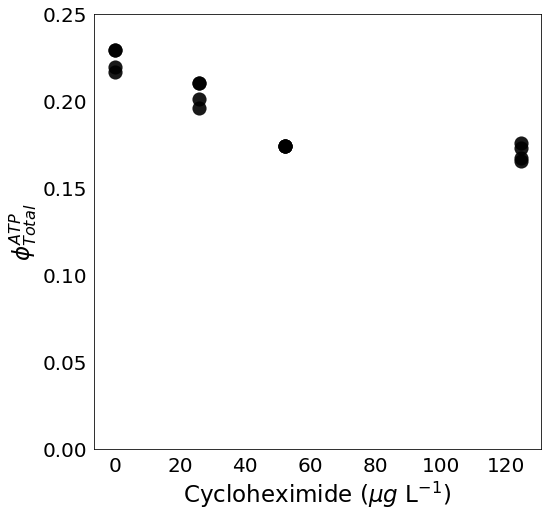

In [15]:
#Plot Figure 
fig, ax = plt.subplots(figsize=(8,8))
ax.patch.set_facecolor('white')
sns.set_context("talk")

ax.patch.set_facecolor('white')
sns.scatterplot(elsemann_rates['Cyclohexamide'], elsemann_rates['value'], color = 'black', alpha=.9, linewidth = 0, s=200, zorder = 4)
ax.set_ylim(0, 0.25)
#ax.set_xlim(-0.02, 0.6)

#axis format
ax.set_xlabel("Cycloheximide (" r'$ \mu g$ $ \mathrm{L}^{-1} $)', fontsize=23)
ax.set_ylabel("$ \phi^{ATP}_{Total} $", fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=20, left=False, bottom=False)

#save figure
fig.savefig('./Figures/fig_cycloheximide_treatment.svg',format='svg', dpi=1200)

In [16]:
slope, intercept, r_value, p_value, std_err = stats.linregress(elsemann_rates['glu60'],elsemann_rates['value'])

In [17]:
x = np.arange(-.1,1, .01)
y = slope * x + intercept

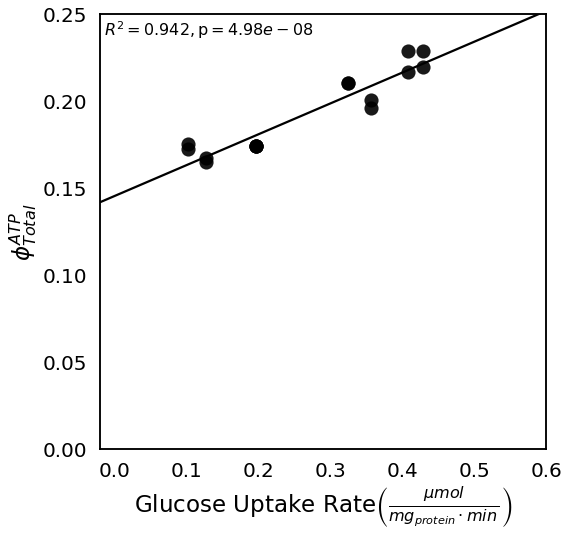

In [18]:
#Plot Figure 
fig, ax = plt.subplots(figsize=(8,8))
ax.patch.set_facecolor('white')
sns.set_context("talk")

ax.patch.set_facecolor('white')
sns.scatterplot(elsemann_rates['glu60'], elsemann_rates['value'], color = 'black', alpha=.9, linewidth = 0, s=200, zorder = 4)
ax.set_ylim(0, 0.25)
ax.set_xlim(-0.02, 0.6)

sns.lineplot(x=x, y=y, color = 'black')

#axis format
ax.set_xlabel("Glucose Uptake Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=23)
ax.set_ylabel("$ \phi^{ATP}_{Total} $", fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=20, left=False, bottom=False)


tl = ((ax.get_xlim()[1] - ax.get_xlim()[0])*0.010 + ax.get_xlim()[0],
      (ax.get_ylim()[1] - ax.get_ylim()[0])*0.95 + ax.get_ylim()[0])
ax.text(tl[0], tl[1], r"$ R^2 = {}, $p$ = {}$".format(round(r_value, 3), round(p_value, 10)), fontsize = 16)

#save figure
fig.savefig('./Figures/fig_cycloheximide_glucose_expansion.svg',format='svg', dpi=1200)

In [19]:
def warburgLoop(rates, proteomics, ferm_proteomics, resp_proteomics, gly_proteomics, Y_Glyc, Y_Resp, min_gluc, max_gluc, organism): 
    
    '''Performs bootstrapping to resample the five parameter estimates (i.e. fraction of 
    the proteome occupied by pathway, specific activity, and ATP yield) with replacement (N=10,000). 
    After each round of sampling, the specific activity of each pathway is calculated. The sampled 
    parameter values for proteome occupied by pathway, specific activity, and ATP yield from each 
    round of bootstrapping are used in the linear program described in the function above. 
    All 10,000 results are stored in a data frame, which in the output.'''

    results_final = []
    
       
    for j in tqdm(range(10000)):
        V_Resp = []
        V_Glyc = []
        Mass_Fract_ATP = []
    
        #random choice with replacement for each paramter 
        sample_activity_respiration = rates.loc[rates['pathway'] == 'Respiration', 'glucose uptake rate  (mmol gprotein-1 hr-1)'].unique() / 60
        #print(sample_activity_respiration)
        sample_activity_fermentation = rates.loc[rates['pathway'] == 'Fermentation', 'glucose uptake rate  (mmol gprotein-1 hr-1)'].unique() / 60
        #print(sample_activity_fermentation)
        sample_mass_respiraition = resp_proteomics.loc[(resp_proteomics['estimate'] == 'respiration'), 'value'].unique()
        #print(sample_mass_respiraition)
        sample_mass_fermentation = ferm_proteomics.loc[(ferm_proteomics['estimate'] == 'fermentation'), 'value'].unique()
        #print(sample_mass_fermentation)
        sample_mass_ATP = proteomics['value'].unique()
        sample_mass_glycolysis = gly_proteomics.loc[(gly_proteomics['estimate'] == 'fermentation'), 'value'].unique() 
        
        sample_size_activity_respiration = len(sample_activity_respiration)
        sample_size_activity_fermentation = len(sample_activity_fermentation)
        sample_size_mass_respiraition = len(sample_mass_respiraition)
        sample_size_mass_fermentation = len(sample_mass_fermentation)
        sample_size_mass_ATP = len(sample_mass_ATP)
        sample_size_mass_glycolysis= len(sample_mass_glycolysis)
    
        sample_specific_activity_fermentation = np.random.choice(sample_activity_fermentation, size=sample_size_activity_fermentation,replace=True)
        sample_specific_activity_respiration = np.random.choice(sample_activity_respiration, size=sample_size_activity_respiration, replace=True)
        sample_fraction_fermentation = np.random.choice(sample_mass_fermentation, size=sample_size_mass_fermentation, replace=True)
        sample_fraction_respiration = np.random.choice(sample_mass_respiraition, size=sample_size_mass_respiraition, replace=True)
        sample_fraction_ATP = np.random.choice(sample_mass_ATP, size=sample_size_mass_ATP, replace=True)
        sample_fraction_glycolysis = np.random.choice(sample_mass_glycolysis, size=sample_size_mass_glycolysis, replace=True)
        
        #calculate model parameters for current bootstrap iteration   
        V_Resp =  sample_specific_activity_respiration.mean() / (sample_fraction_respiration.mean())
        #print(V_Resp)
        V_Glyc = sample_specific_activity_fermentation.mean() / sample_fraction_fermentation.mean() 
        #print(V_Glyc)
        #print(sample_specific_activity_fermentation.mean())
        
        V_Glyc_2 = sample_specific_activity_fermentation.mean() / sample_fraction_glycolysis.mean() 
        
        rate_ratio = V_Resp / V_Glyc_2
        
        V_Resp =  sample_specific_activity_respiration.mean() / (sample_fraction_respiration.mean() + sample_fraction_glycolysis.mean() * rate_ratio)

        #print(V_Glyc)
        #print(V_Resp)
        
        Mass_Fract_ATP = sample_fraction_ATP.mean() 
        #print(Mass_Fract_ATP)
        Y_Glyc = Y_Glyc
        Y_Resp = Y_Resp
        
        #glucose uptake rates to loop through 
        gluc = np.linspace(min_gluc, max_gluc, 200)
        
        #Empty arrays to save results
        glucose_uptake = []
        glyc_mass = []
        resp_mass = []
        atp = []
        lact = []
        o2 = []
    
        #loop through the linear model for each glucose uptake rate
        for i in range(len(gluc)):
            loop_result = (warburgModel(gluc[i], Y_Glyc, Y_Resp, V_Resp, V_Glyc, Mass_Fract_ATP, organism)) 
            #print(loop_result)
            
            glyc_mass.append(loop_result[0])
            resp_mass.append(loop_result[1])
            atp.append(loop_result[2])
            lact.append(loop_result[3])
            o2.append(loop_result[4])
            glucose_uptake.append(gluc[i])
            
        results = [glyc_mass, resp_mass, atp, lact, o2, glucose_uptake]
        
        #Append the outputs for each bootstrap iteration
        results_final.append(results)
    
    #Convert the array into a dataframe
    df = pd.DataFrame({'gluc' : [], 'glyc_mass' : [], 'resp_mass' : [], 'atp' : [], 'lact' : [], 'o2' : []})

    for i in range(len(results_final)):
        df_temp_gluc = pd.DataFrame({'gluc' : results_final[i][5]})
        df_temp_gly = pd.DataFrame({'glyc_mass' : results_final[i][0]})
        df_temp_resp = pd.DataFrame({'resp_mass' : results_final[i][1]})
        df_temp_atp = pd.DataFrame({'atp' : results_final[i][2]})
        df_temp_lac = pd.DataFrame({'lact' : results_final[i][3]})
        df_temp_o2 = pd.DataFrame({'o2' : results_final[i][4]})
        out = df_temp_gluc.join([df_temp_gly, df_temp_resp, df_temp_atp, df_temp_lac, df_temp_o2])
        
        df = pd.concat([df, out])
        
    return(df)

In [20]:
#parameter estimates for proteome occupany
proteomics = pd.read_csv('./Data/2024_02_25_yeast_atp_total_core.csv')

#parameters estimates for specfic activity
rates = pd.read_csv('./Data/yeast_cellular_rates.csv')

#parameters estimates for specfic activity proteome
resp_proteomics = pd.read_csv('./Data/2024_02_25_yeast_specific_activity_resp_core.csv')
ferm_proteomics = pd.read_csv('./Data/2024_02_25_yeast_specific_activity_fermentation.csv')

In [21]:
#data into warburgLoop function
yeast_model_expand = warburgLoop(rates, proteomics, ferm_proteomics, resp_proteomics, ferm_proteomics, 2, 16, 0.1/60, 39/60, 'yeast')

  0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
#calculate confidence interval 
yeast_model_conf_expand = warburgCI(yeast_model_expand)
max_conf_expand = np.array(yeast_model_conf_expand['lact_x'])
min_conf_expand = np.array(yeast_model_conf_expand['lact_y'])
yeast_min_expand = next(i for i, x in enumerate(max_conf_expand) if x > 0)
yeast_max_expand = next(i for i, x in enumerate(min_conf_expand) if x > 0)

#reset index
yeast_model_mean_expand = yeast_model_expand.groupby('gluc').median().reset_index()

In [23]:
elsemann_rates_cyc = elsemann_rates.loc[elsemann_rates['variable'].str.contains('cyc')]

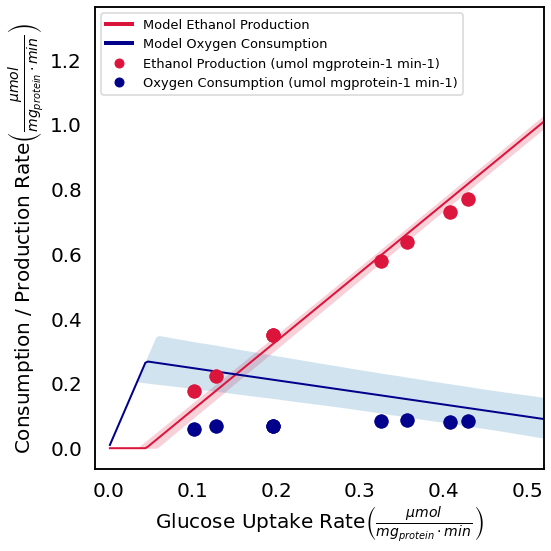

In [24]:
#Plot Figure 3e
#Model predictions of fermentation and respiration rates in S. cerevisiae
fig, ax = plt.subplots(figsize=(8,8))
ax.patch.set_facecolor('white')

#plot model predictions 
ax.plot(yeast_model_mean_expand['gluc'], yeast_model_mean_expand['lact'], color = 'crimson', linewidth = 2, label='Model Ethanol Production')
ax.fill_between(yeast_model_mean_expand['gluc'], yeast_model_conf_expand['lact_y'], yeast_model_conf_expand['lact_x'], color = 'crimson', alpha=0.2, linewidth = 0)
ax.plot(yeast_model_mean_expand['gluc'], yeast_model_mean_expand['o2'], color = 'darkblue', linewidth = 2, label='Model Oxygen Consumption')
ax.fill_between(yeast_model_mean_expand['gluc'],yeast_model_conf_expand['o2_y'], yeast_model_conf_expand['o2_x'], alpha=0.2, linewidth = 0)

#plot experimental data
sns.scatterplot(elsemann_rates_cyc['glucose']/60, elsemann_rates_cyc['qEth']/60/.44, color = 'crimson', alpha=.9, label='Experimental Ethanol Production', linewidth = 0, s=200, zorder = 3)
sns.scatterplot(elsemann_rates_cyc['glucose']/60, elsemann_rates_cyc['qO2']/60/-.44, color = 'darkblue', alpha=.9, label='Experimental Oxygen Consumption', linewidth = 0, s=200, zorder = 4)

#sns.scatterplot(yeast_experiments_sugar['Glucose Uptake Rate']/60, yeast_experiments_sugar['qEtOH']/60, color = 'crimson', alpha=.9, label='Experimental Ethanol Production', linewidth = 0, s=200, zorder = 3, style = yeast_experiments['Author'])
#sns.scatterplot(yeast_experiments_sugar['Glucose Uptake Rate']/60, yeast_experiments_sugar['qO2']/60, color = 'darkblue', alpha=.9, label='Experimental Oxygen Consumption', linewidth = 0, s=200, zorder = 4, style = yeast_experiments['Author'])

#axis format
ax.set_xlabel("Glucose Uptake Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=20)
ax.set_ylabel("Consumption / Production Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20, left=False, bottom=False)
ax.set_xlim(-1/60, 0.52)

#legend format 
custom = [Line2D([0], [0], color='crimson', lw=4),
          Line2D([0], [0], color='darkblue', lw=4),
          Line2D([], [], marker='o', color='crimson', linestyle='None'),
          Line2D([], [], marker='o', color='darkblue', linestyle='None')]
plt.legend(custom, ['Model Ethanol Production', 'Model Oxygen Consumption', 'Ethanol Production (umol mgprotein-1 min-1)', 'Oxygen Consumption (umol mgprotein-1 min-1)'], fontsize = 13, loc='upper left')


plt.tight_layout()

#save figure
fig.savefig('./Figures/fig_yeast_rates_perdiction_expand.svg',format='svg', dpi=1200)

In [25]:
def warburgLoop(rates, proteomics, ferm_proteomics, resp_proteomics, gly_proteomics, Y_Glyc, Y_Resp, min_gluc, max_gluc, organism): 
    
    '''Performs bootstrapping to resample the five parameter estimates (i.e. fraction of 
    the proteome occupied by pathway, specific activity, and ATP yield) with replacement (N=10,000). 
    After each round of sampling, the specific activity of each pathway is calculated. The sampled 
    parameter values for proteome occupied by pathway, specific activity, and ATP yield from each 
    round of bootstrapping are used in the linear program described in the function above. 
    All 10,000 results are stored in a data frame, which in the output.'''

    results_final = []
    
       
    for j in tqdm(range(10000)):
        V_Resp = []
        V_Glyc = []
        Mass_Fract_ATP = []
    
        #random choice with replacement for each paramter 
        sample_activity_respiration = rates.loc[rates['pathway'] == 'Respiration', 'glucose uptake rate  (mmol gprotein-1 hr-1)'].unique() / 60
        #print(sample_activity_respiration)
        sample_activity_fermentation = rates.loc[rates['pathway'] == 'Fermentation', 'glucose uptake rate  (mmol gprotein-1 hr-1)'].unique() / 60
        #print(sample_activity_fermentation)
        sample_mass_respiraition = resp_proteomics.loc[(resp_proteomics['estimate'] == 'respiration'), 'value'].unique()
        #print(sample_mass_respiraition)
        sample_mass_fermentation = ferm_proteomics.loc[(ferm_proteomics['estimate'] == 'fermentation'), 'value'].unique()
        #print(sample_mass_fermentation)
        sample_mass_ATP = proteomics['value'].unique()
        sample_mass_glycolysis = gly_proteomics.loc[(gly_proteomics['estimate'] == 'fermentation'), 'value'].unique() 
        
        sample_size_activity_respiration = len(sample_activity_respiration)
        sample_size_activity_fermentation = len(sample_activity_fermentation)
        sample_size_mass_respiraition = len(sample_mass_respiraition)
        sample_size_mass_fermentation = len(sample_mass_fermentation)
        sample_size_mass_ATP = len(sample_mass_ATP)
        sample_size_mass_glycolysis= len(sample_mass_glycolysis)
    
        sample_specific_activity_fermentation = np.random.choice(sample_activity_fermentation, size=sample_size_activity_fermentation,replace=True)
        sample_specific_activity_respiration = np.random.choice(sample_activity_respiration, size=sample_size_activity_respiration, replace=True)
        sample_fraction_fermentation = np.random.choice(sample_mass_fermentation, size=sample_size_mass_fermentation, replace=True)
        sample_fraction_respiration = np.random.choice(sample_mass_respiraition, size=sample_size_mass_respiraition, replace=True)
        sample_fraction_ATP = np.random.choice(sample_mass_ATP, size=sample_size_mass_ATP, replace=True)
        sample_fraction_glycolysis = np.random.choice(sample_mass_glycolysis, size=sample_size_mass_glycolysis, replace=True)
        
        #if organism == 'mammalian': 
            #sample_volume = volume['Volume (fl)']
            #sample_size_volume= len(sample_volume)
            #sample_volume_values = np.random.choice(sample_volume, size=sample_size_volume, replace=True)
            #print(sample_volume_values.mean())
            #calculate model parameters for current bootstrap iteration   
            #V_Resp =  sample_specific_activity_respiration.mean() / (sample_fraction_respiration.mean()) / 300 * sample_volume_values.mean() * .128
            ##print(V_Resp)
            #V_Glyc = sample_specific_activity_fermentation.mean() / sample_fraction_fermentation.mean() / 300 * sample_volume_values.mean() * .128
            #V_Glyc_2 = sample_specific_activity_fermentation.mean() / sample_fraction_glycolysis.mean() 
            #rate_ratio = V_Resp / V_Glyc_2
            #V_Resp =  (sample_specific_activity_respiration.mean() / 300 * sample_volume_values.mean() * .128) / (sample_fraction_respiration.mean() + sample_fraction_glycolysis.mean() * rate_ratio)

        
        #else: 
        #calculate model parameters for current bootstrap iteration   
        V_Resp =  sample_specific_activity_respiration.mean() / (sample_fraction_respiration.mean())
        #print(V_Resp)
        V_Glyc = sample_specific_activity_fermentation.mean() / sample_fraction_fermentation.mean() 
        #print(V_Glyc)
        #print(sample_specific_activity_fermentation.mean())
        V_Glyc_2 = sample_specific_activity_fermentation.mean() / sample_fraction_glycolysis.mean() 
        rate_ratio = V_Resp / V_Glyc_2
        V_Resp =  sample_specific_activity_respiration.mean() / (sample_fraction_respiration.mean() + sample_fraction_glycolysis.mean() * rate_ratio)

        #print(V_Glyc)
        #print(V_Resp)
        
        #Mass_Fract_ATP = sample_fraction_ATP.mean()
        
        #print(Mass_Fract_ATP)
        Y_Glyc = Y_Glyc
        Y_Resp = Y_Resp
        
        #glucose uptake rates to loop through 
        gluc = np.linspace(min_gluc, max_gluc, 200)
        
        #Empty arrays to save results
        glucose_uptake = []
        glyc_mass = []
        resp_mass = []
        atp = []
        lact = []
        o2 = []
    
        #loop through the linear model for each glucose uptake rate
        for i in range(len(gluc)):
            Mass_Fract_ATP = .1759 * gluc + 0.143
            #Mass_Fract_ATP = 0.143 + gluc * 0
            loop_result = (warburgModel(gluc[i], Y_Glyc, Y_Resp, V_Resp, V_Glyc, Mass_Fract_ATP[i], organism)) 
            #print(loop_result)
            
            glyc_mass.append(loop_result[0])
            resp_mass.append(loop_result[1])
            atp.append(loop_result[2])
            lact.append(loop_result[3])
            o2.append(loop_result[4])
            glucose_uptake.append(gluc[i])
            
        results = [glyc_mass, resp_mass, atp, lact, o2, glucose_uptake]
        
        #Append the outputs for each bootstrap iteration
        results_final.append(results)
    
    #Convert the array into a dataframe
    df = pd.DataFrame({'gluc' : [], 'glyc_mass' : [], 'resp_mass' : [], 'atp' : [], 'lact' : [], 'o2' : []})

    for i in range(len(results_final)):
        df_temp_gluc = pd.DataFrame({'gluc' : results_final[i][5]})
        df_temp_gly = pd.DataFrame({'glyc_mass' : results_final[i][0]})
        df_temp_resp = pd.DataFrame({'resp_mass' : results_final[i][1]})
        df_temp_atp = pd.DataFrame({'atp' : results_final[i][2]})
        df_temp_lac = pd.DataFrame({'lact' : results_final[i][3]})
        df_temp_o2 = pd.DataFrame({'o2' : results_final[i][4]})
        out = df_temp_gluc.join([df_temp_gly, df_temp_resp, df_temp_atp, df_temp_lac, df_temp_o2])
        
        df = pd.concat([df, out])
        
    return(df)

In [26]:
#parameter estimates for proteome occupany
proteomics = pd.read_csv('./Data/2024_02_25_yeast_atp_total_core.csv')

#parameters estimates for specfic activity
rates = pd.read_csv('./Data/yeast_cellular_rates.csv')

#parameters estimates for specfic activity proteome
resp_proteomics = pd.read_csv('./Data/2024_02_25_yeast_specific_activity_resp_core.csv')
ferm_proteomics = pd.read_csv('./Data/2024_02_25_yeast_specific_activity_fermentation.csv')

In [27]:
#data into warburgLoop function
yeast_model_expand = waburgLoop(rates, proteomics, ferm_proteomics, resp_proteomics, ferm_proteomics, 2, 16, 0.1/60, 39/60, 'yeast')

NameError: name 'waburgLoop' is not defined

In [ ]:
#calculate confidence interval 
yeast_model_conf_expand = warburgCI(yeast_model_expand)
max_conf_expand = np.array(yeast_model_conf_expand['lact_x'])
min_conf_expand = np.array(yeast_model_conf_expand['lact_y'])
yeast_min_expand = next(i for i, x in enumerate(max_conf_expand) if x > 0)
yeast_max_expand = next(i for i, x in enumerate(min_conf_expand) if x > 0)

#reset index
yeast_model_mean_expand = yeast_model_expand.groupby('gluc').median().reset_index()

In [ ]:
#elsemann_rates_gly = elsemann_rates.loc[(elsemann_rates['type'] == 'glycolysis')  & (elsemann_rates['variable'].str.contains('cyc'))]

In [ ]:
elsemann_rates_cyc = elsemann_rates.loc[elsemann_rates['variable'].str.contains('cyc')]

In [ ]:
#Plot Figure 3e
#Model predictions of fermentation and respiration rates in S. cerevisiae
fig, ax = plt.subplots(figsize=(8,8))
ax.patch.set_facecolor('white')

#plot model predictions 
ax.plot(yeast_model_mean_expand['gluc'], yeast_model_mean_expand['lact'], color = 'crimson', linewidth = 2, label='Model Ethanol Production')
ax.fill_between(yeast_model_mean_expand['gluc'], yeast_model_conf_expand['lact_y'], yeast_model_conf_expand['lact_x'], color = 'crimson', alpha=0.2, linewidth = 0)
ax.plot(yeast_model_mean_expand['gluc'], yeast_model_mean_expand['o2'], color = 'darkblue', linewidth = 2, label='Model Oxygen Consumption')
ax.fill_between(yeast_model_mean_expand['gluc'],yeast_model_conf_expand['o2_y'], yeast_model_conf_expand['o2_x'], alpha=0.2, linewidth = 0)

#plot experimental data
sns.scatterplot(elsemann_rates_cyc['glucose']/60, elsemann_rates_cyc['qEth']/60/.44, color = 'crimson', alpha=.9, label='Experimental Ethanol Production', linewidth = 0, s=200, zorder = 3)
sns.scatterplot(elsemann_rates_cyc['glucose']/60, elsemann_rates_cyc['qO2']/60/-.44, color = 'darkblue', alpha=.9, label='Experimental Oxygen Consumption', linewidth = 0, s=200, zorder = 4)

#sns.scatterplot(yeast_experiments_sugar['Glucose Uptake Rate']/60, yeast_experiments_sugar['qEtOH']/60, color = 'crimson', alpha=.9, label='Experimental Ethanol Production', linewidth = 0, s=200, zorder = 3, style = yeast_experiments['Author'])
#sns.scatterplot(yeast_experiments_sugar['Glucose Uptake Rate']/60, yeast_experiments_sugar['qO2']/60, color = 'darkblue', alpha=.9, label='Experimental Oxygen Consumption', linewidth = 0, s=200, zorder = 4, style = yeast_experiments['Author'])

#axis format
ax.set_xlabel("Glucose Uptake Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=20)
ax.set_ylabel("Consumption / Production Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20, left=False, bottom=False)
ax.set_xlim(-1/60, 0.52)

#legend format 
custom = [Line2D([0], [0], color='crimson', lw=4),
          Line2D([0], [0], color='darkblue', lw=4),
          Line2D([], [], marker='o', color='crimson', linestyle='None'),
          Line2D([], [], marker='o', color='darkblue', linestyle='None')]
plt.legend(custom, ['Model Ethanol Production', 'Model Oxygen Consumption', 'Ethanol Production (umol mgprotein-1 min-1)', 'Oxygen Consumption (umol mgprotein-1 min-1)'], fontsize = 13, loc='upper left')


plt.tight_layout()

#save figure
fig.savefig('./Figures/fig_yeast_rates_perdiction_expand_2.svg',format='svg', dpi=1200)